In [142]:
import pandas as pd
import numpy as np
from scipy.sparse.csgraph import reverse_cuthill_mckee
from scipy.sparse import csr_matrix
import matplotlib.pylab as plt
import scipy.sparse as sps
from random import randint
import operator

In [46]:
class Dataframe:
    
    dataframe = None # datframe iniziale
    dataframe_bandizzato = None # dataframe after RCM e square
    items_final = None # lista di tutti i prodotti indicizzati con colonna
    lista_sensibili = None # lista prodotti sensibili
    original_band = None
    band_after_rcm = None
    
    def __init__(self,nome_file=None):
        """
            Costruttore che legge il file csv
        """
        self.dataframe = pd.read_csv(nome_file,header=None,index_col=None)
        
    def compute_band_matrix(self,dim_finale = 1000, nome_file_item = None, num_sensibile = 1):
        """
            Compute band_matrix , permutazione casuale di righe e colonne
            estrapola a caso item_sensibili
        """
        original_dataset = self.dataframe
        if original_dataset is not None and len(original_dataset) >= dim_finale and len(original_dataset.columns) >= dim_finale:

            # leggo nomi items
            file = open(nome_file_item, "r")
            items = file.read().splitlines()

            # permuto righe e colonne del df inizale e prendo le prime :dim_finale
            np.random.seed(seed=13)
            random_column = np.random.permutation(original_dataset.shape[1])[:dim_finale]
            random_row = np.random.permutation(original_dataset.shape[0])[:dim_finale]
            # recupero gli item selezionati nel relativo ordine == colonne
            items_reordered = [items[i] for i in random_column]

            # df selezionato e square
            # eliminare le righe nulle a priori
            df_square = original_dataset.iloc[random_row][random_column];
            # eliminare solo se items sensibili nulli

            # selezioni gli utlimi num_sensibili come item sensibili
            # check se esiste almeno un item sensibile

            # remove dati sensibili add zero --> compute RCM --> remove zero e add dati sensibili
            # df_sensibili = df_square[df_square.columns[-num_sensibile:]]
            # df_common_items = df_square[df_square.columns[0:-num_sensibile]]
            # zero_data_to_add = np.zeros(shape=(len(df_common_items),num_sensibile))
            # columns_to_add = ["temp_"+str(x) for x in range(0,num_sensibile)]
            # df_zeri = pd.DataFrame(zero_data_to_add, columns=columns_to_add,index=df_common_items.index,dtype='uint8')
            # df_square = pd.concat([df_common_items,df_zeri],axis=1)
            # print(df_zeri.shape) dim_finalexnum_sensibili
            # print(df_square.shape)
            # subplot with y condiviso

            f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

            # check che le colonne sensibili non siano nulle
            lista_sensibili = df_square.columns[-num_sensibile:]
            # plot matrice sparsa iniziale
            # plt
            ax1.spy(df_square, marker='.', markersize='1')
            #ax1.show()

            # applicazione algoritmo RCM
            sparse = csr_matrix(df_square)
            order = reverse_cuthill_mckee(sparse)

            # solo se add gli 0
            # riordino i dati sensibili
            # df_sensibili = df_sensibili.iloc[order]

            # ora devo prendere gli item selzionati prima e riordinarli ancora
            # secondo quello scritto in order quindi
            items_final = [items_reordered[i] for i in order]
            column_reordered = [df_square.columns[i] for i in order]
            # creo gl item indicizzati con la colonna
            items_final = dict(zip(column_reordered,items_final))
            # df bandizzato
            df_square_band = df_square.iloc[order][column_reordered]
            # plotto
            ax2.spy(df_square_band, marker='.', markersize='1')
            #ax2.show()
            plt.show()
            # banda dataframe inizale
            [i, j] = np.where(df_square == 1)
            bw = max(i-j) + 1
            self.original_band = bw
            print("Bandwidth first RCM", bw)

            # banda dataframe dopo RCM
            [i, j] = np.where(df_square_band == 1)
            bw = max(i-j) + 1
            self.band_after_rcm = bw
            print("Bandwidth after RCM", bw)

            self.dataframe_bandizzato = df_square_band
            self.items_final = items_final
            self.lista_sensibili = lista_sensibili


In [179]:
class AnonymizationCAHD:
    
    # DATA
    dataframe_bandizzato = None # dataframe after RCM
    items_sensibili = None # list all sensibile data
    nome_item = None # dict index--> nome_item
    grado_privacy = None # grado privacy richiesto
    alfa = None # controllo le alfa * grado_privacy transizoni
    hist = None # hist delle frequenze dei dati sensibili
    transizioni_sensibili = None # id transizioni sensibii
    transizioni_sensibili_all = None # tutte le transizioni mapping con ite sensibii
    items_sensibili_per_tranzioni = None
    
    dict_group = None
    dataframe_anonimizzato = None
    lista_gruppi = None
    sd_gruppi = None
    
    def __init__(self, dataframe=None, grado_privacy=4, alfa = 3):
        """
            Anonymization through CAHD algorithm , euristico and greedy
        """
        self.dataframe_bandizzato = dataframe.dataframe_bandizzato.copy()
        self.items_sensibili = dataframe.lista_sensibili
        self.nome_item = dataframe.items_final
        self.grado_privacy = grado_privacy
        self.alfa = alfa
    
    def compute_hist(self):
        self.hist = dict(self.dataframe_bandizzato[self.items_sensibili].sum())
        print(self.hist)
    
    def check_grado_privacy(self):
        """
        compute se il grado della privacy può essere soddisfatto, se così non fosse
        si diminuisce il grado della privacy per averne uno ottimale, oppure si può
        decidere di modificare gli item sensibili
        """
        for value in self.hist.values():
            if value * self.grado_privacy >=len(self.dataframe_bandizzato)-1:
                return False
        return True
    
    def get_id_transazioni_sensibili(self):
        self.transazioni_sensibili = set(list(np.where(self.dataframe_bandizzato[self.items_sensibili] == 1)[0]))
        self.transizioni_sensibili_all = list(np.where(self.dataframe_bandizzato[self.items_sensibili] == 1)[0])
        # item sensibili della transazione iesime
        self.item_sensibile_per_transazioni = list(np.where(self.dataframe_bandizzato[self.items_sensibili] == 1)[1])

    def check_conflict(self, row_i, row_j):
        # se hanno un items sensibile in comune allora sono in conflitto
        dati_sensibili_row_i = self.items_sensibili[np.where(self.dataframe_bandizzato.iloc[row_i][self.items_sensibili] == 1)]
        dati_sensibili_row_j = self.items_sensibili[np.where(self.dataframe_bandizzato.iloc[row_j][self.items_sensibili] == 1)]
        # create set
        set_j = set(dati_sensibili_row_j)
        set_i = set(dati_sensibili_row_i)
        # check intersection
        return len(set_i.intersection(set_j)) > 0
    
    def select_best_transactions(self, candidate_list, transaction_target):
        all_items = list(self.dataframe_bandizzato)
        QID_items = [x for x in all_items if x not in self.items_sensibili]

        #lista riportante gli item in comune con transactionTarget
        distance = list()    
        # remove list che hanno items_sensibili in comune
        # bisogna controllare che nella lista candidate non vi siano transizioni in conflitto con loro

        #for id in index[0]:

        for row in candidate_list:
            list1 = self.dataframe_bandizzato.iloc[transaction_target][QID_items]
            list2 = self.dataframe_bandizzato.iloc[row][QID_items]
            #da queste due liste, devo escludere le transazioni sensibili.

            #num. elementi in comune di due liste
            distance.append(sum([x and y for x, y in zip(list1, list2)]))

        #ottengo i p-1 indici della lista candidata con distanza maggiore
        major_indexs = list()
        for i in range(0, self.grado_privacy-1):
            max_index,max_value = max(enumerate(distance), key=operator.itemgetter(1))
            major_indexs.append(max_index)
            distance[max_index] = -1

        #seleziono gli indici delle righe del dataframe con maggior QIitems in comune
        best_rows = list()
        for i in major_indexs:
            best_rows.append(candidate_list[i])

        return best_rows


    def compute_candidate_list(self, indice_transizione_sensibile):
        alpha_p = self.alfa * self.grado_privacy
        lc = list()  # lista candidate
        k = 1
        # controllo gli alpha*p transazioni precedenti non sono in conflitto
        cond = max(indice_transizione_sensibile - alpha_p - k, -1)
        i = indice_transizione_sensibile - 1;
        while (i > cond):
            if self.check_conflict(indice_transizione_sensibile, i):
                k = k + 1
            else:
                # controllo che nella lista non vi siano gia delle
                # transizioni con quelli item sensibili
                # se si non la posso inserire
                conflitto_lista = False
                for index in lc:
                    if self.check_conflict(index, i):
                        conflitto_lista = True
                        break
                if not conflitto_lista:
                    lc.append(i)
                else:
                    k = k + 1

            cond = max(indice_transizione_sensibile - alpha_p - k, -1)
            i -= 1

        # alpha*p transizioni successive che non sono in conflitto
        k = 1
        cond = min(indice_transizione_sensibile + alpha_p + k, len(self.dataframe_bandizzato))
        i = indice_transizione_sensibile + 1
        while(i < cond):
            
            if self.check_conflict(indice_transizione_sensibile, i):
                k = k + 1
            else:
                conflitto_lista = False
                for index in lc:
                    if self.check_conflict(index, i):
                        conflitto_lista = True
                        break
                if not conflitto_lista:
                    lc.append(i)
                else:
                    k = k + 1
            cond = min(indice_transizione_sensibile + alpha_p + k, len(self.dataframe_bandizzato))
            i += 1
        # controllo se per caso rimangano item sensibili nella lista allora li rimuovo
        to_remove = list()
        for i in range(0,len(lc)-1):
            for j in range(i+1,len(lc)):
                if self.check_conflict(lc[i],lc[j]):
                    to_remove.append(lc[j])
                    #print("conflitto")
        to_remove = list(set(to_remove))
        #print(to_remove)
        for remove in to_remove:
            lc.remove(remove)

        error = False
        if len(lc) < self.grado_privacy:
            error = True

        return lc, error

        
    
    def CAHD_algorithm(self):
        """
            algoritmo di anonimizzazion
        """
        self.compute_hist()
        soddisfabile = False
        while not soddisfabile and self.grado_privacy > 0:
            soddisfabile = self.check_grado_privacy()
            if not soddisfabile:
                self.grado_privacy -= 1
        print("grado di privacy soddisfabile: ", self.grado_privacy)
        # lunghezza del dataframe
        remaining = len(self.dataframe_bandizzato)
        # compute le transizioni sensibili
         # inidice delle righe delle transazioni sensibili non ripetute
        # indice delle transizioni sensibili con mapping 1-1 con item_sensibile_per_transizione
        # transazioni_sensibili_completa[i] --> indice della transizione
        # item_sensibile_per_transazioni[i] --> item sensibile per la transizione sopra
        self.get_id_transazioni_sensibili()
        # riempo il dizionario (hash_map) indicizzata con il numero della riga
        for t in self.transazioni_sensibili:
            index_t = np.where(np.array(self.transizioni_sensibili_all) == t)[0]

        
        lc = dict()     # lista candidata
        #FORMO IL DATAFRAME ANONIMIZZATO [item sensibili sono riportati a destra]
        #Nota: codice aggiunto. Molti di questi argomenti possono essere passati esternamente e passati a loro volta
        #a funzioni interne
        df_square = self.dataframe_bandizzato.copy()
        all_items = list(df_square.columns)
        QID_items = [x for x in all_items if x not in self.items_sensibili]
        columns_list = QID_items.copy()
        for x in self.items_sensibili:
            columns_list.append(x)
        # dataframe anonimizzato dopo aver sopostato tutte le colonne degli item sensibili a destra
        dataframe_anonimizzato = pd.DataFrame(columns = columns_list,index = df_square.index)
        dict_group = list()
        
        # index delle row del datframe bandizzato relativo alle row sensibili
        id_sensitive_transaction = self.dataframe_bandizzato.iloc[list(self.transazioni_sensibili)].index

        #Ciclo finchè ho gruppi da anonimizzare
        done = False

        # lista dei gruppi con i relativi dati sensibili all'interno
        lista_gruppi =list()
        sd_gruppi = list()

        #indice che cicla tra gli id_delle transazioni sensibili
        ts_index = 0
        while not done:
            #se ho terminato di scorrere la lista delle transazioni sensibili esco dal ciclo
            if(ts_index > len(id_sensitive_transaction)-1):
                done = True
                break
                
            #seleziono la iesima transazione sensibile
            q = id_sensitive_transaction[ts_index]
            #passo da label a num.di riga
            t = self.dataframe_bandizzato.index.get_loc(q)

            #nel caso di cancellazioni, devo aggiornare la lista degli indici delle transazioni sensibili
            transazioni_sensibili = list()
            for i in id_sensitive_transaction:
                transazioni_sensibili.append(self.dataframe_bandizzato.index.get_loc(i))

            #lista candidata LC
            lc,errore = self.compute_candidate_list( t)
            # se posso creare il gruppo
            if not errore:
                group = self.select_best_transactions(lc, t)
                #aggiungo la transazione bersaglio
                group.append(t)

                # somma degli items sensibili del gruppo iesimo relativo
                selected_sensitive_items = self.dataframe_bandizzato.iloc[group][self.items_sensibili].sum()
                # temp hist
                temp_hist = self.hist.copy()
                # aggiorno le occorrenze di ogni item sensbile

                for index in selected_sensitive_items.index:
                    temp_hist[index] -= selected_sensitive_items.loc[index]

                # controllo se il gruppo creato va bene
                found = False
                for index in temp_hist.keys():
                    # se non si può più soddisfare il grado di privacy

                    if temp_hist[index] * self.grado_privacy > remaining:
                        found = True
                        ts_index += 1
                        break

                # se il gruppo invece va bene
                if not found:
                    # update hist
                    self.hist = temp_hist.copy()
                    #DEVO RIMUOVERE EVENTUALI TRANSAZIONI SENSIBILI COMPRESE NEL GRUPPO DA id_sensitive_transaction
                    label_group = self.dataframe_bandizzato.iloc[group].index
                    id_sensitive_transaction = [x for x in id_sensitive_transaction if x not in label_group]

                    # indice iesimo -> indice delle transazioni del gruppo iesimo
                    dict_group.append(self.dataframe_bandizzato.index[group])

                    # metto i QID nel datframe anonimizzato
                    dataframe_anonimizzato.loc[list(self.dataframe_bandizzato.index[group])] = \
                    self.dataframe_bandizzato.loc[list(self.dataframe_bandizzato.index[group])]

                    lista_gruppi.append(self.dataframe_bandizzato.loc[list(self.dataframe_bandizzato.index[group]),QID_items])

                    for index in list(self.dataframe_bandizzato.index[group]):
                        # metto la somma dei SD del gruppo per ogni row del gruppo
                        dataframe_anonimizzato.loc[index][selected_sensitive_items.index] = selected_sensitive_items

                    sd_gruppi.append(selected_sensitive_items) # aggiungo somma item sensibili relativi al gruppo iesimo

                    # le droppo dal df iniziale
                    self.dataframe_bandizzato = self.dataframe_bandizzato.drop(list(self.dataframe_bandizzato.index[group]))

                    # compute row rimanenti
                    remaining = len(self.dataframe_bandizzato.index)

            else:
                ts_index += 1

        #terminato il ciclo di formazione dei gruppi, mi rimane un supergruppo con le transazioni sensibili rimanenti o meno.

        # somma item sensibili nel gruppo rimasto
        #for i in range(0,dataframe_bandizzato.shape[0]):
        #    transaction = dataframe_bandizzato.index[i]
        #    dataframe_anonimizzato.loc[transaction] = dataframe_bandizzato.iloc[i]

        # update del dataframe anonimizzato con il super gruppo finale
        selected_sensitive_items = self.dataframe_bandizzato[self.items_sensibili].sum()
        dataframe_anonimizzato.loc[self.dataframe_bandizzato.index] = self.dataframe_bandizzato
        # metto la somma degli item
        for index in list(self.dataframe_bandizzato.index):
            dataframe_anonimizzato.loc[index,self.items_sensibili]= selected_sensitive_items
        lista_gruppi.append(self.dataframe_bandizzato[QID_items])
        sd_gruppi.append(selected_sensitive_items)
        # del datframe iniziale
        self.dataframe_bandizzato = None
        self.sd_gruppi = sd_gruppi
        self.lista_gruppi = lista_gruppi
        self.dict_group = dict_group
        
        

In [180]:
df = Dataframe('online_retail_transaction.csv')

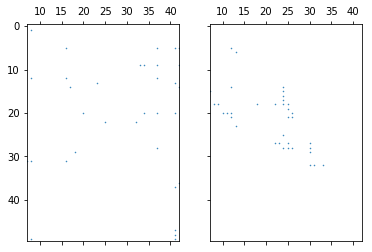

Bandwidth first RCM 42
Bandwidth after RCM 11


In [181]:
df.compute_band_matrix(dim_finale=50,nome_file_item="lista_items.txt",num_sensibile=4)

In [182]:
cahd = AnonymizationCAHD(df)

In [183]:
cahd.CAHD_algorithm()

{407: 2, 2207: 0, 459: 0, 3608: 0}
grado di privacy soddisfabile:  4


In [184]:
cahd.sd_gruppi

[407     1
 2207    0
 459     0
 3608    0
 dtype: int64, 407     1
 2207    0
 459     0
 3608    0
 dtype: int64, 407     0
 2207    0
 459     0
 3608    0
 dtype: int64]

In [185]:
cahd.lista_gruppi

[      2835  1108  1669  1736  1335  3822  1640  1830  369   27    ...   1216  \
 1179     0     0     0     0     0     0     0     0     0     0  ...      0   
 1396     0     0     0     1     0     0     0     0     0     0  ...      0   
 2678     0     0     0     0     0     0     0     0     0     0  ...      0   
 2686     0     0     0     0     0     0     0     0     0     0  ...      0   
 
       233   928   2619  3437  4175  797   4188  1236  1688  
 1179     0     0     0     0     0     0     0     0     0  
 1396     0     0     0     0     0     0     0     0     0  
 2678     0     0     0     0     0     0     0     0     0  
 2686     0     0     0     0     0     0     0     0     0  
 
 [4 rows x 46 columns],
       2835  1108  1669  1736  1335  3822  1640  1830  369   27    ...   1216  \
 1213     0     0     0     0     0     0     0     0     0     0  ...      0   
 1278     0     0     0     0     0     0     0     0     0     0  ...      0   
 3968     0   